In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


Descripcion de los datos:

El dataset a utilizar en la elaboracion del proyecto final de la materia de Analisis Estadistico Multivariado proviene de 'https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17'.

Nuestros datos consisten en 100,000 observaciones con 17 features y una columna target.

- obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- alpha = Right Ascension angle (at J2000 epoch)
- delta = Declination angle (at J2000 epoch)
- u = Ultraviolet filter in the photometric system
- g = Green filter in the photometric system
- r = Red filter in the photometric system
- i = Near Infrared filter in the photometric system
- z = Infrared filter in the photometric system
- run_ID = Run Number used to identify the specific scan
- rereun_ID = Rerun Number to specify how the image was processed
- cam_col = Camera column to identify the scanline within the run
- field_ID = Field number to identify each field
- spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
- class = object class (galaxy, star or quasar object) (Target)
- redshift = redshift value based on the increase in wavelength
- plate = plate ID, identifies each plate in SDSS
- MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
- fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [302]:
datos = pd.read_csv('star_classification.csv')
datos.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


<Axes: >

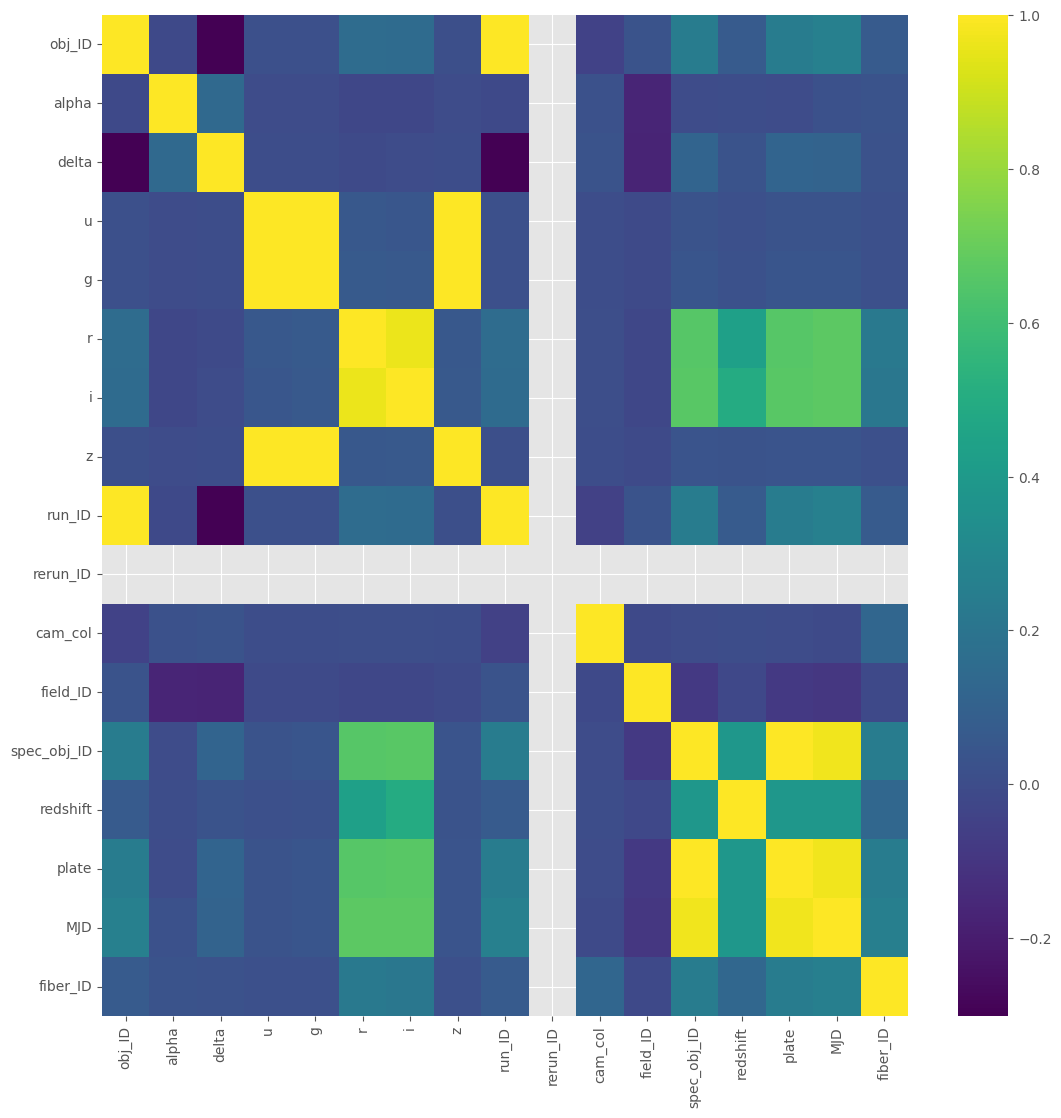

In [303]:
X = datos.drop(columns=['class'], axis=1)
Y = datos['class']

sns.heatmap(X.corr(), annot=False, fmt='.2f', cmap='viridis')

C:\Users\Josué\AppData\Local\Temp\ipykernel_29276\1094626748.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=datos, palette='pastel')


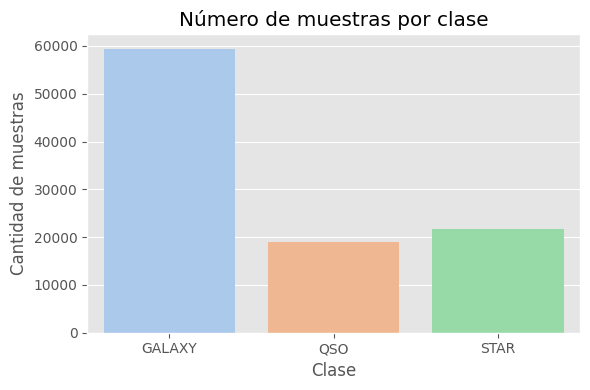

In [304]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=datos, palette='pastel')

plt.title('Número de muestras por clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de muestras')
plt.tight_layout()
plt.show()

C:\Users\Josué\AppData\Local\Temp\ipykernel_29276\3341841181.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=datos, x=var, hue='class', fill=True, common_norm=False, alpha=0.7, ax=ax, palette=palette)


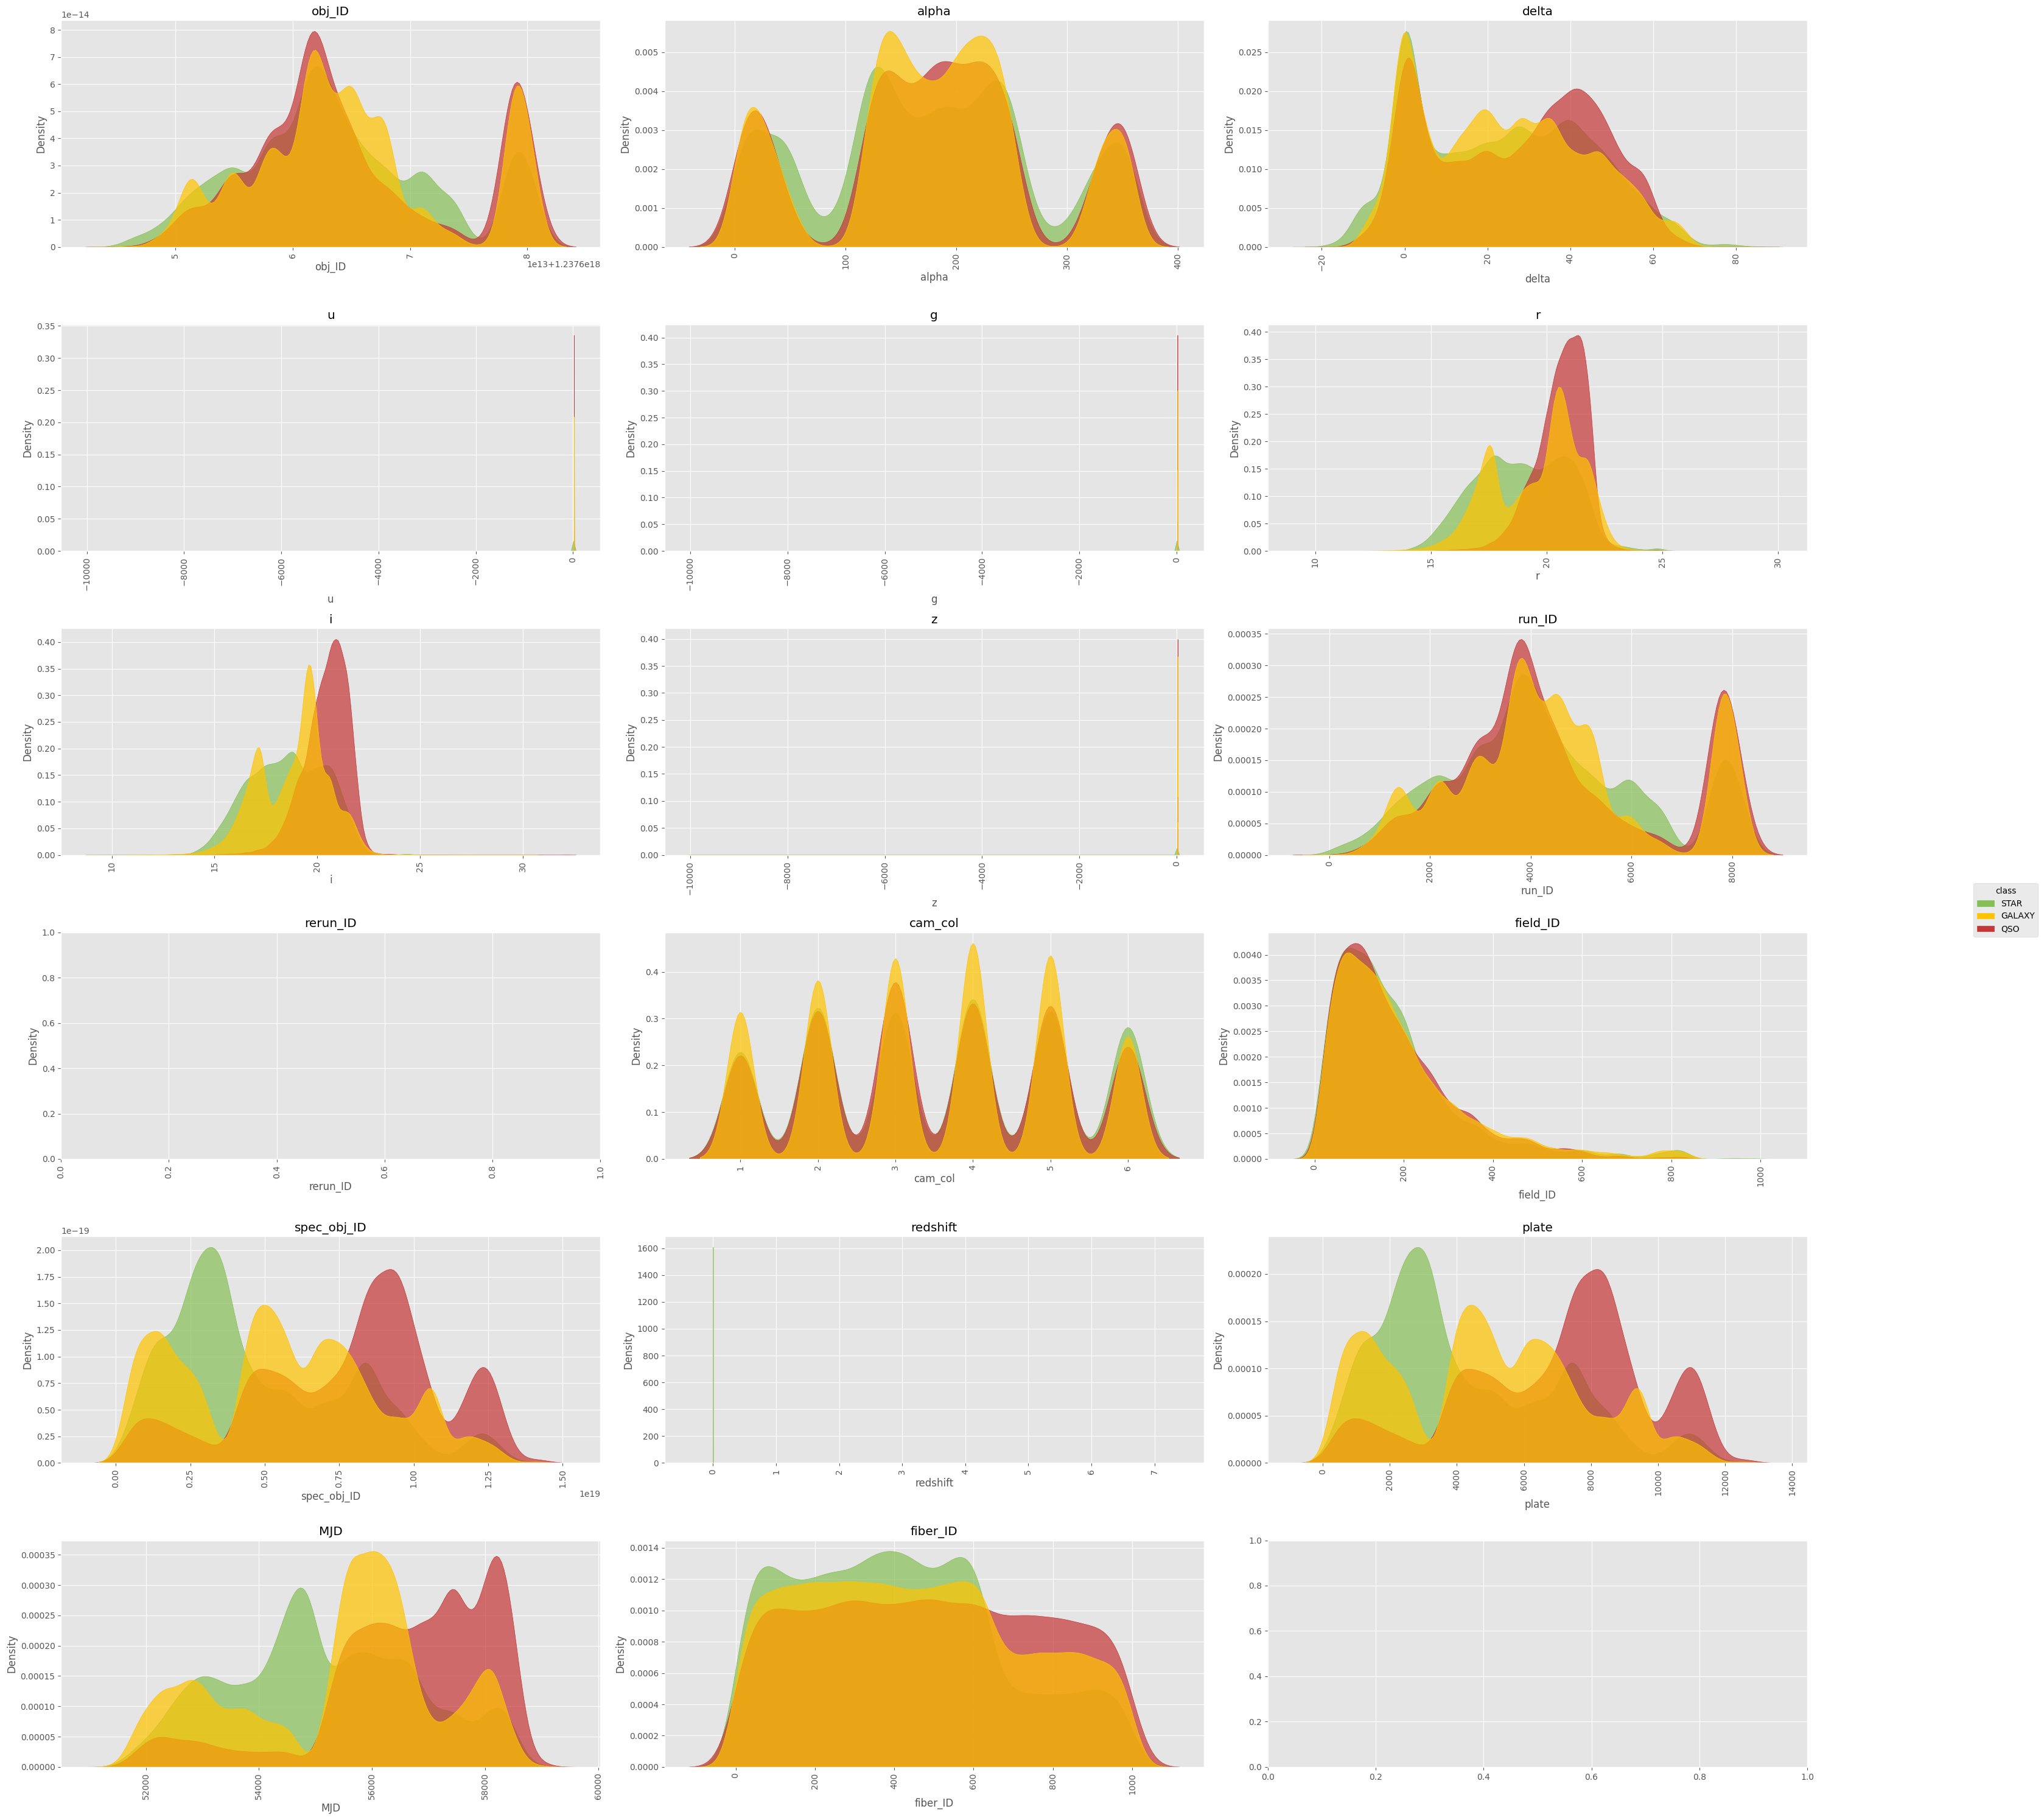

In [305]:
# Filtrar variables numéricas
numeric_vars = datos.select_dtypes(include='number').columns.tolist()

# Crear grid 6x3
fig, axes = plt.subplots(6, 3, figsize=(30, 30))
axes = axes.flatten()

# Paleta de colores
palette = {'STAR': '#86bf55', 'GALAXY': '#ffc300', 'QSO': '#c53636'}

# Gráficos
for i, var in enumerate(numeric_vars):
    ax = axes[i]
    sns.kdeplot(data=datos, x=var, hue='class', fill=True, common_norm=False, alpha=0.7, ax=ax, palette=palette)
    ax.set_title(var)
    ax.tick_params(axis='x', rotation=90)
    ax.get_legend().remove()

# Leyenda
legend_patches = [Patch(color=color, label=label) for label, color in palette.items()]
fig.legend(handles=legend_patches, title='class', loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout()
plt.show()

Planteamiento del modelado

1. Modelo RegLog Simple
2. Modelo RegLog + Feature Selection
3. Modelo RegLog + PCA
4. Modelo RegLog + Clustering
5. Modelo RegLog + Feature Selection + PCA + Clustering

In [306]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [307]:
RegLog = LogisticRegression()
RegLog.fit(x_train, y_train)

LogisticRegression()

In [308]:
y_pred = RegLog.predict(x_test)

In [309]:
RegLog.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [310]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')

Accuracy: 0.60025
Precision: 0.45835863709359753


C:\Users\Josué\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1-Score: 0.478439562483232
Recall: 0.60025


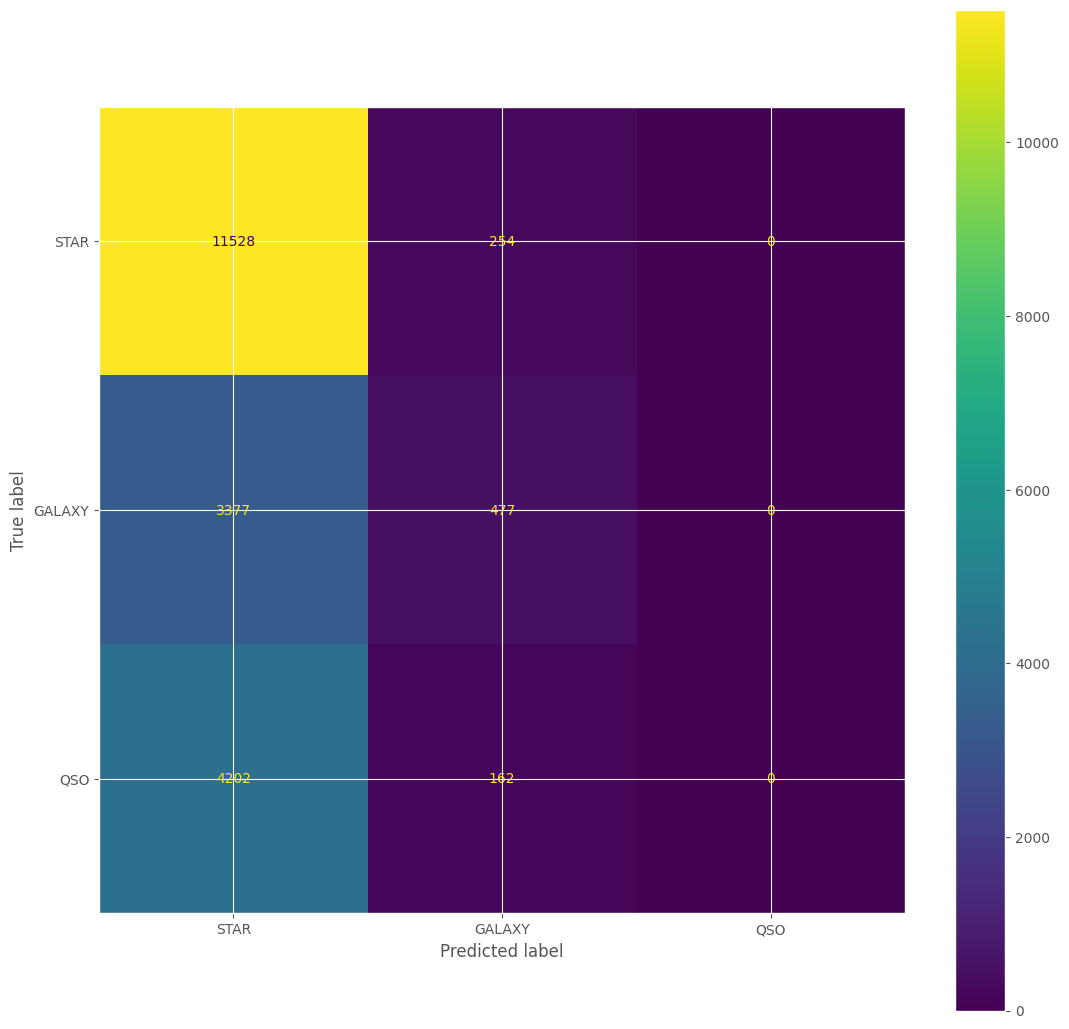

In [311]:
cmv1 = confusion_matrix(y_test, y_pred)
cmv1_display = ConfusionMatrixDisplay(cmv1, display_labels=['STAR', 'GALAXY', 'QSO'])
cmv1_display.plot()
plt.show()


PRIMER MODELO MEJORADO

In [312]:
# Separar variables (X) y la etiqueta/clase (y)
X = datos.drop(columns='class')  # Todas las columnas excepto 'class'
y = datos['class']               # Solo la columna de clase

In [ ]:

# 1. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 2. Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Escalar los datos después del SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Solo transformas el test, sin fit

# Ahora puedes entrenar tu modelo con X_train_scaled y y_train_resampled


In [314]:

RegLog_scaled = LogisticRegression(penalty='l2', solver='lbfgs')

In [315]:
RegLog_scaled.fit(X_train_scaled, y_train_resampled)


C:\Users\Josué\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [316]:
y_pred = RegLog_scaled.predict(X_test_scaled)
y_prob = RegLog_scaled.predict_proba(X_test_scaled)  # Probabilidad de la clase positiva

In [317]:
RegLog_scaled.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [318]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob,multi_class='ovr',average='weighted'):.4f}")

Accuracy: 0.94976
Precision: 0.9504434391786144
F1-Score: 0.9497026459002275
Recall: 0.94976
AUC-ROC: 0.9855


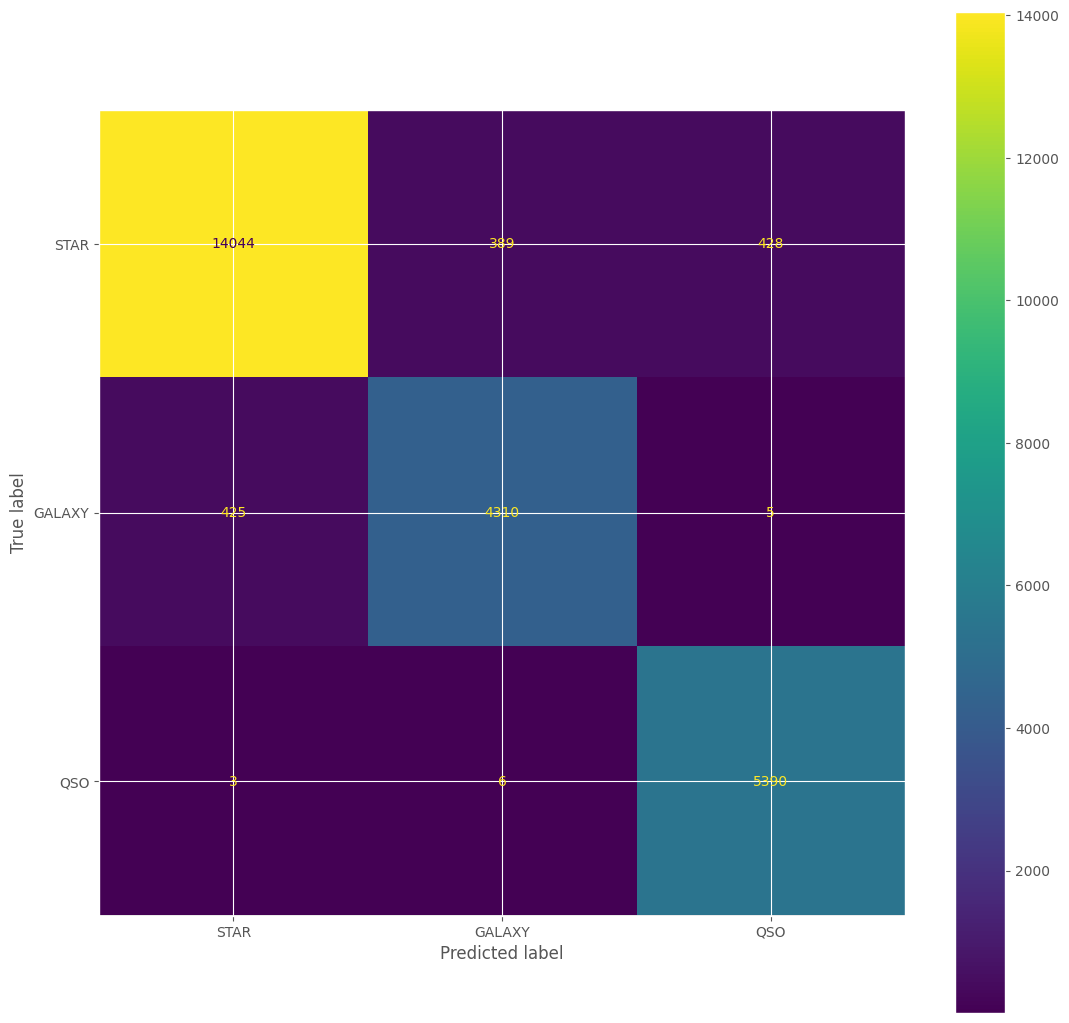

In [319]:
cmv2 = confusion_matrix(y_test, y_pred)
cmv2_display = ConfusionMatrixDisplay(cmv2, display_labels=['STAR', 'GALAXY', 'QSO'])
cmv2_display.plot()
plt.show()


SELECCION DE VARIABLES PARA EL MODELO

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [323]:
#%% 2. Función para filtrado con VIF
def vif_filtering(dataframe, threshold=5):
    predictors = dataframe.drop(columns=['class'])
    features = list(predictors.columns)
    
    while True:
        # Calcular VIF para cada variable
        vif_data = pd.DataFrame()
        vif_data['variable'] = features
        vif_data['VIF'] = [variance_inflation_factor(predictors[features].values, i) 
                           for i in range(len(features))]
        
        # Si el máximo VIF es mayor al umbral, se elimina la variable correspondiente
        max_vif = vif_data['VIF'].max()
        if max_vif > threshold:
            variable_to_drop = vif_data.loc[vif_data['VIF'].idxmax(), 'variable']
            features.remove(variable_to_drop)
        else:
            break
    return features

selected_vif = vif_filtering(datos, threshold=5)
print("\n[Filtro - VIF] Variables seleccionadas:", selected_vif)

C:\Users\Josué\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Josué\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Josué\AppData\Roaming\Python\Python311\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\Josué\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss



[Filtro - VIF] Variables seleccionadas: ['alpha', 'delta', 'z', 'run_ID', 'cam_col', 'field_ID', 'redshift', 'fiber_ID']


In [324]:
X_selected=datos[['alpha', 'delta', 'z', 'run_ID', 'cam_col', 'field_ID', 'redshift', 'fiber_ID']]

MODELO

In [325]:

# 1. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, stratify=y, random_state=42)

# 2. Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Escalar los datos después del SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Solo transformas el test, sin fit

# Ahora puedes entrenar tu modelo con X_train_scaled y y_train_resampled

In [326]:

RegLog_scaled = LogisticRegression(penalty='l2', solver='lbfgs')

In [327]:
RegLog_scaled.fit(X_train_scaled, y_train_resampled)

LogisticRegression()

In [328]:
y_pred = RegLog_scaled.predict(X_test_scaled)
y_prob = RegLog_scaled.predict_proba(X_test_scaled)  # Probabilidad de la clase positiva

In [329]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob,multi_class='ovr',average='weighted'):.4f}")

Accuracy: 0.92356
Precision: 0.9243123088726056
F1-Score: 0.9233443872987127
Recall: 0.92356
AUC-ROC: 0.9728


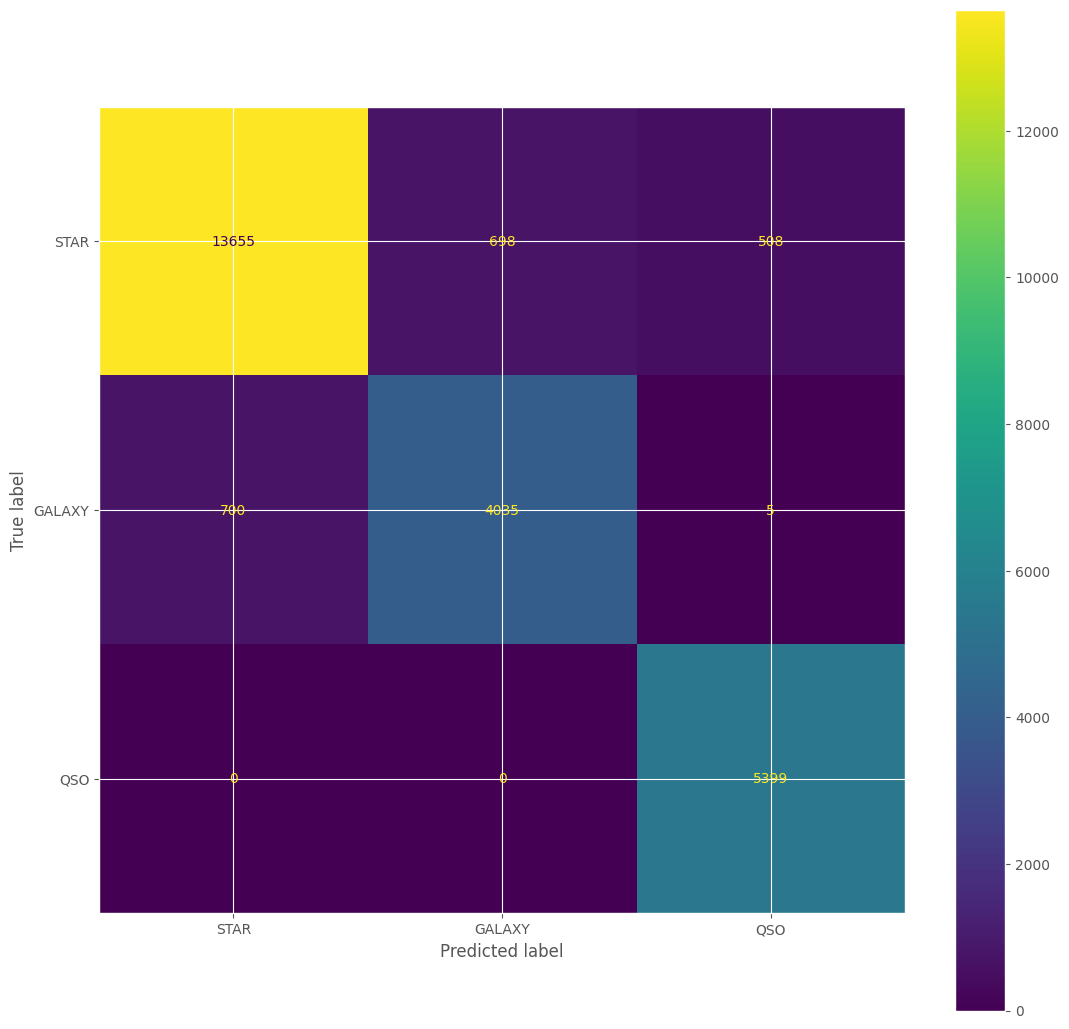

In [330]:
cmv2 = confusion_matrix(y_test, y_pred)
cmv2_display = ConfusionMatrixDisplay(cmv2, display_labels=['STAR', 'GALAXY', 'QSO'])
cmv2_display.plot()
plt.show()

PCA

In [332]:
X = datos.drop(columns=['class'], axis=1)
Y = datos['class']

In [333]:

# 1. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=42)

# 2. Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Escalar los datos después del SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Solo transformas el test, sin fit



In [334]:
pca=PCA()
X_train_transformada = pca.fit_transform(X_train_scaled)
X_test_transformada = pca.transform(X_test_scaled)
print(X_train_scaled.shape)
print(X_train_transformada.shape)

(133752, 17)
(133752, 17)


In [335]:
X_train_transformed = pd.DataFrame(X_train_transformada, columns = ['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8','CP9','CP10','CP11','CP12','CP13','CP14','CP15','CP16', 'CP17'])
X_test_transformed = pd.DataFrame(X_test_transformada, columns = ['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8','CP9','CP10','CP11','CP12','CP13','CP14','CP15','CP16', 'CP17'])
X_train_transformed

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11,CP12,CP13,CP14,CP15,CP16,CP17
0,-2.454393,0.298792,0.958615,-1.580026,-1.594845,0.085987,-1.378950,0.450532,-0.444824,-0.698347,-0.155047,-0.263736,0.009184,0.003332,0.000030,-1.292562e-05,3.376889e-14
1,-2.725317,0.087305,1.830839,0.879993,-0.502999,-0.642586,-1.022032,0.372613,-0.034391,0.684548,0.003117,0.086719,-0.023018,-0.000425,0.000044,-5.590550e-06,1.857428e-14
2,2.590338,-0.266938,-1.801370,1.181098,0.375411,-0.412746,-0.242016,0.156845,-0.272902,1.087866,-0.278704,-0.027425,-0.025612,-0.009268,0.000056,-5.590264e-07,7.549947e-15
3,0.466811,0.023646,0.218047,-0.708011,1.606047,-0.278121,-1.021429,1.601467,0.136891,-0.477229,0.131107,-0.067078,-0.021320,0.011303,0.000027,-3.033044e-06,1.033472e-14
4,-2.390325,0.249219,-1.421363,0.575621,0.812049,1.676785,-0.546721,-0.139375,-1.471188,-0.162456,-0.232122,0.081461,-0.002877,-0.003717,0.000042,-9.161222e-06,2.631762e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133747,-0.775907,-0.072991,0.495522,-1.152502,-1.649750,-2.073998,0.202482,0.485644,-1.476296,1.202558,0.018464,0.122578,-0.014171,-0.002588,-0.000062,1.057876e-04,-2.643118e-13
133748,-2.386128,0.226310,0.475153,0.302659,-0.408262,0.349604,0.379818,-0.577634,-0.055901,-0.415499,0.093577,-0.253980,0.017577,0.001950,-0.000154,-1.746434e-05,2.867687e-14
133749,1.654203,-0.066522,-1.161789,0.436764,0.066763,-0.823801,-1.236105,-1.194554,-0.617739,-1.111749,0.047437,0.283408,-0.000354,-0.010729,-0.000362,1.121223e-04,-3.058230e-13
133750,1.039728,-0.099678,1.995575,2.317456,0.134390,-0.014488,0.006395,-1.227639,-0.119343,-0.591267,-0.179347,0.102853,0.020530,-0.015040,0.000043,-4.121655e-06,1.353555e-14


In [336]:
#%% Validate the "recommended" PCA's
w,v = np.linalg.eig(pca.get_covariance()) # Get vectors for covariance matrix
w=np.abs(w)
indx = np.argsort(w)[::-1] # sort
porcentaje = w[indx]/np.sum(w) # convert to %
porcent_acum = np.cumsum(porcentaje) # Accumulate
porcent_acum

array([0.2873085 , 0.47381495, 0.60342511, 0.68212526, 0.74962154,
       0.80951596, 0.86289034, 0.91321797, 0.95708011, 0.99529357,
       0.99766189, 0.9999443 , 0.99998978, 1.        , 1.        ,
       1.        , 1.        ])

In [337]:
X_train = X_train_transformed[['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8']]
X_test = X_test_transformed[['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8']]

In [338]:
RegLog_pca = LogisticRegression(penalty='l2', solver='lbfgs')

In [339]:
RegLog_pca.fit(X_train, y_train_resampled)

LogisticRegression()

In [340]:
y_pred = RegLog_pca.predict(X_test)
y_prob = RegLog_pca.predict_proba(X_test)  # Probabilidad de la clase positiva

In [341]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob,multi_class='ovr',average='weighted'):.4f}")

Accuracy: 0.58304
Precision: 0.6343411598052894
F1-Score: 0.5911472437384221
Recall: 0.58304
AUC-ROC: 0.7553


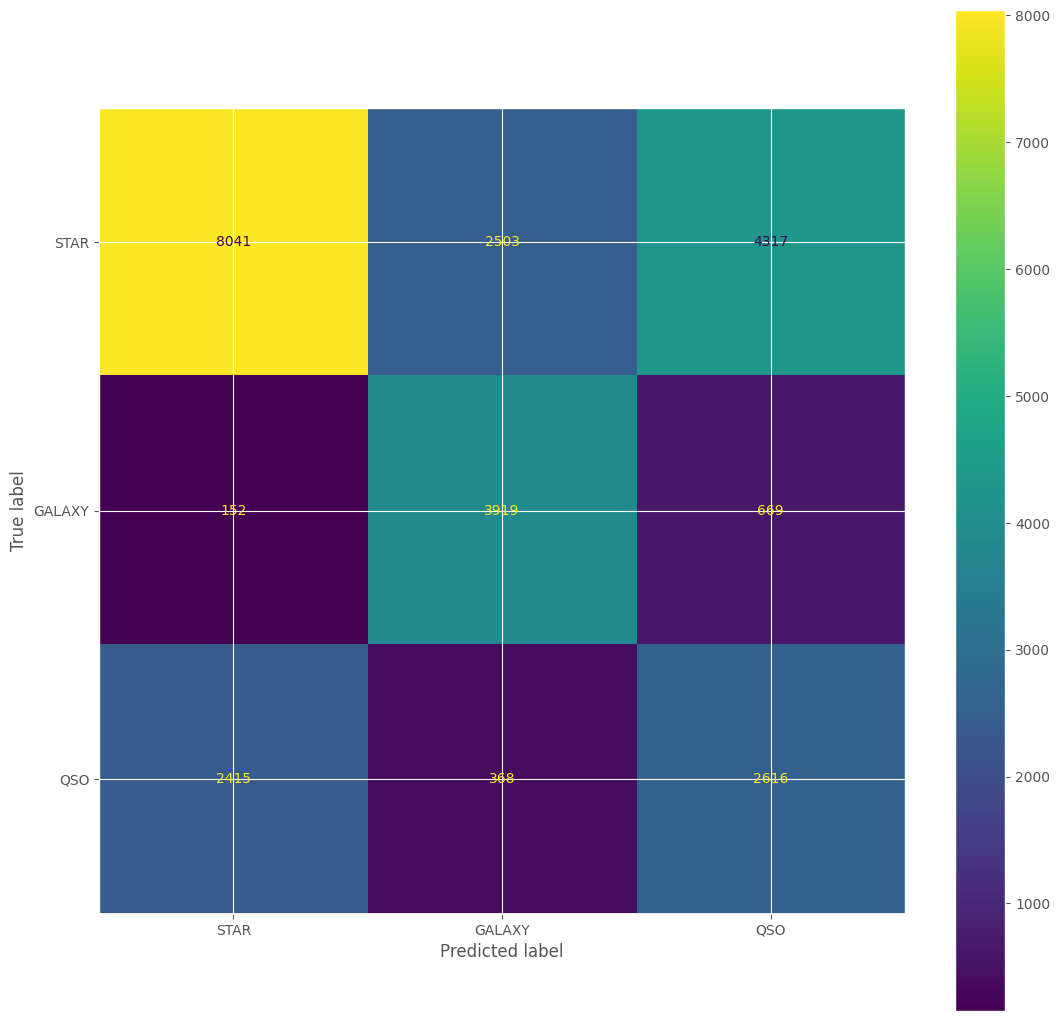

In [342]:
cmv2 = confusion_matrix(y_test, y_pred)
cmv2_display = ConfusionMatrixDisplay(cmv2, display_labels=['STAR', 'GALAXY', 'QSO'])
cmv2_display.plot()
plt.show()

CLUSTERING

In [ ]:

plt.rcParams['figure.figsize'] = (13, 13)
plt.style.use('ggplot')

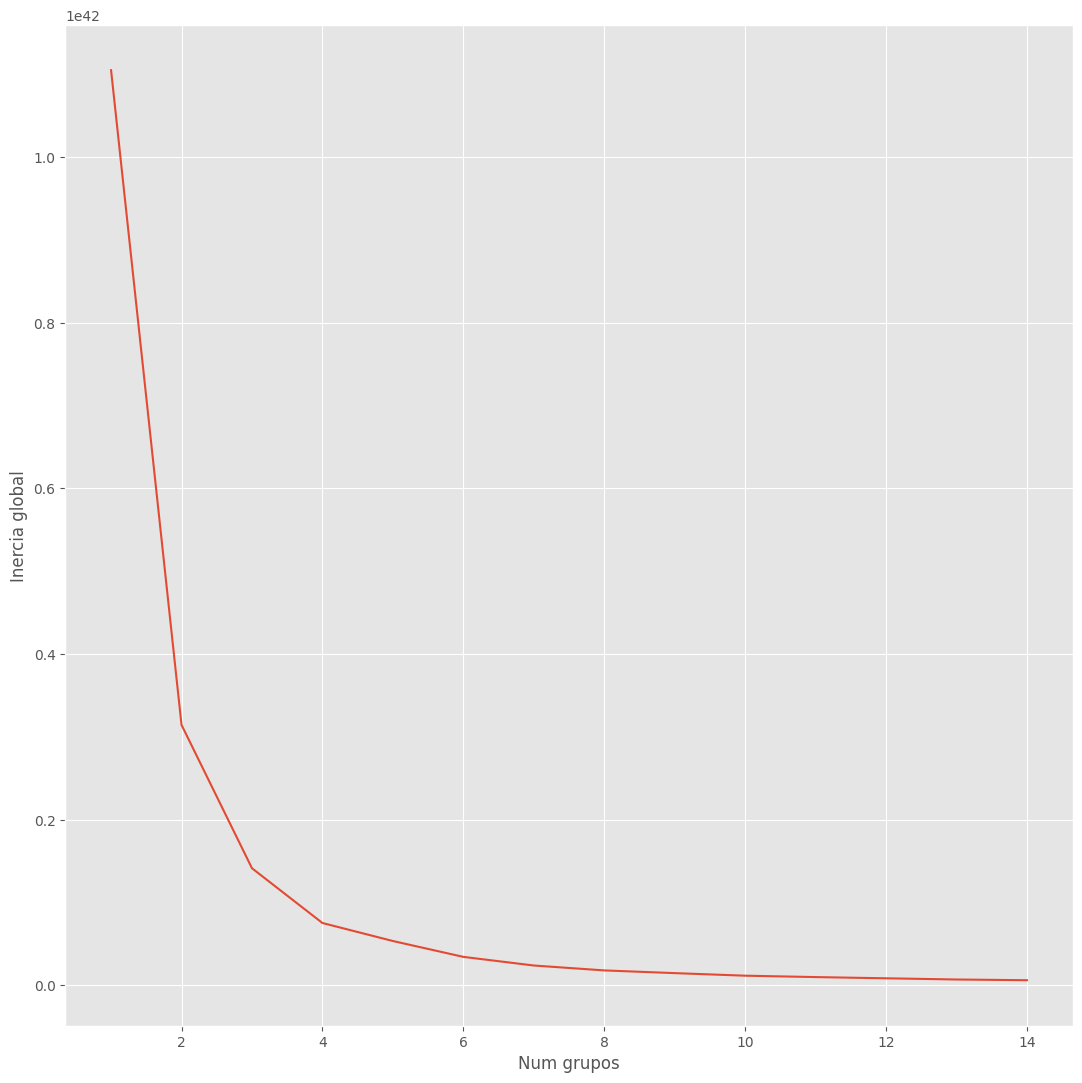

In [344]:
#%% Obtener el número ideal de clústers
# Método de codo
# Existen otros como:Criterio de Calinski, Affinity propagation (AP)
# Gap, dendogramas

inercias = np.zeros(15)
for k in np.arange(1,15):
    model = KMeans(n_clusters=k,init='random',n_init='auto')
    model = model.fit(X)
    inercias[k] = model.inertia_
    
plt.plot(np.arange(1,15),inercias[1:])
plt.xlabel('Num grupos')
plt.ylabel('Inercia global')
plt.show()

In [345]:
df=datos.copy()

[[1.23766542e+18 1.91564982e+02 2.31609199e+01 2.31774372e+01
  2.13937904e+01 2.01453893e+01 1.94541038e+01 1.90999473e+01
  4.64323952e+03 3.01000000e+02 3.50100957e+00 1.79026144e+02
  5.80868145e+18 6.48256725e-01 5.15902179e+03 5.58962117e+04
  5.06407028e+02]
 [1.23766652e+18 1.65504764e+02 2.68685673e+01 2.26710300e+01
  2.18133116e+01 2.10049526e+01 2.04430251e+01 2.01084889e+01
  4.90034341e+03 3.01000000e+02 3.52911764e+00 1.75322811e+02
  9.83616108e+18 9.22004944e-01 8.73614177e+03 5.75815751e+04
  5.08384613e+02]
 [1.23766220e+18 1.72365646e+02 2.27282567e+01 1.98979173e+01
  1.82925051e+01 1.77682866e+01 1.73643652e+01 1.67975266e+01
  3.89321738e+03 3.01000000e+02 3.50781397e+00 2.04807036e+02
  1.93934496e+18 1.65869073e-01 1.72240485e+03 5.33444124e+04
  3.25375384e+02]]


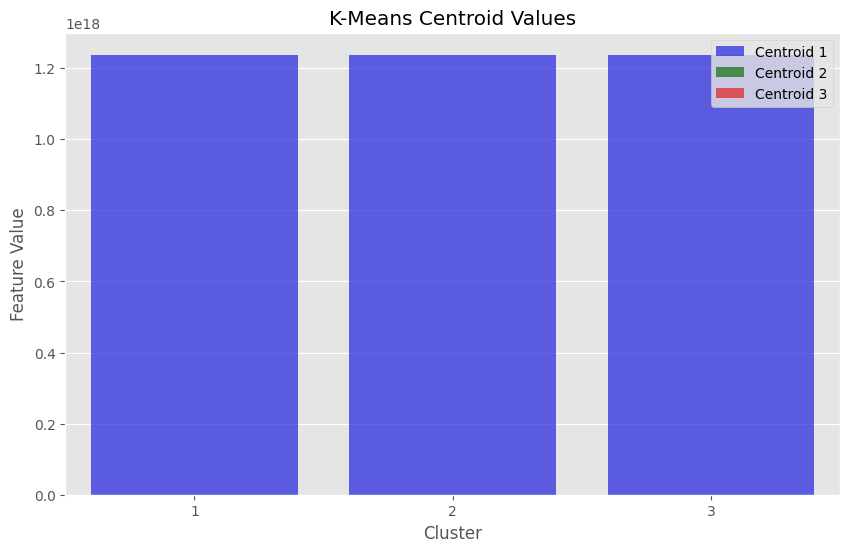

In [346]:
#%% Algoritmo de cluster
kmeans = KMeans(n_clusters=3,init='k-means++',n_init='auto', random_state=42).fit(X)
#init='random'
#init='ndarray'
# Obtener los centroides
df['cluster'] = kmeans.fit_predict(X)
C = kmeans.cluster_centers_
print(C)


# Configura el estilo de Seaborn
#sns.set(style="whitegrid")
# Crea un gráfico de barras para los centroides
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(C) + 1), y=C[:, 0], color='blue', alpha=0.7, label='Centroid 1')
sns.barplot(x=np.arange(1, len(C) + 1), y=C[:, 1], color='green', alpha=0.7, label='Centroid 2')
sns.barplot(x=np.arange(1, len(C) + 1), y=C[:, 2], color='red', alpha=0.7, label='Centroid 3')
plt.title('K-Means Centroid Values')
plt.xlabel('Cluster')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

In [347]:
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,cluster
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171,0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427,1
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299,0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775,1
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438,1
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866,1
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74,2
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470,0


In [348]:
df = pd.get_dummies(df, columns=['cluster'], prefix='cluster', drop_first=True, dtype=float)


In [349]:
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,cluster_1,cluster_2
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171,0.0,0.0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427,1.0,0.0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299,0.0,0.0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775,1.0,0.0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438,1.0,0.0
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866,1.0,0.0
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74,0.0,1.0
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470,0.0,0.0


In [350]:
X = df.drop(columns=['class'], axis=1)
Y = df['class']

In [ ]:

# 1. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=42)

# 2. Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Escalar los datos después del SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Solo transformas el test, sin fit


In [352]:
RegLog_cluster = LogisticRegression(penalty='l2', solver='lbfgs')

In [353]:
RegLog_cluster.fit(X_train_scaled, y_train_resampled)

C:\Users\Josué\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [354]:
y_pred = RegLog_cluster.predict(X_test_scaled)
y_prob = RegLog_cluster.predict_proba(X_test_scaled)  # Probabilidad de la clase positiva

In [355]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')

Accuracy: 0.94924
Precision: 0.9500084473982058
F1-Score: 0.9491899773874972
Recall: 0.94924


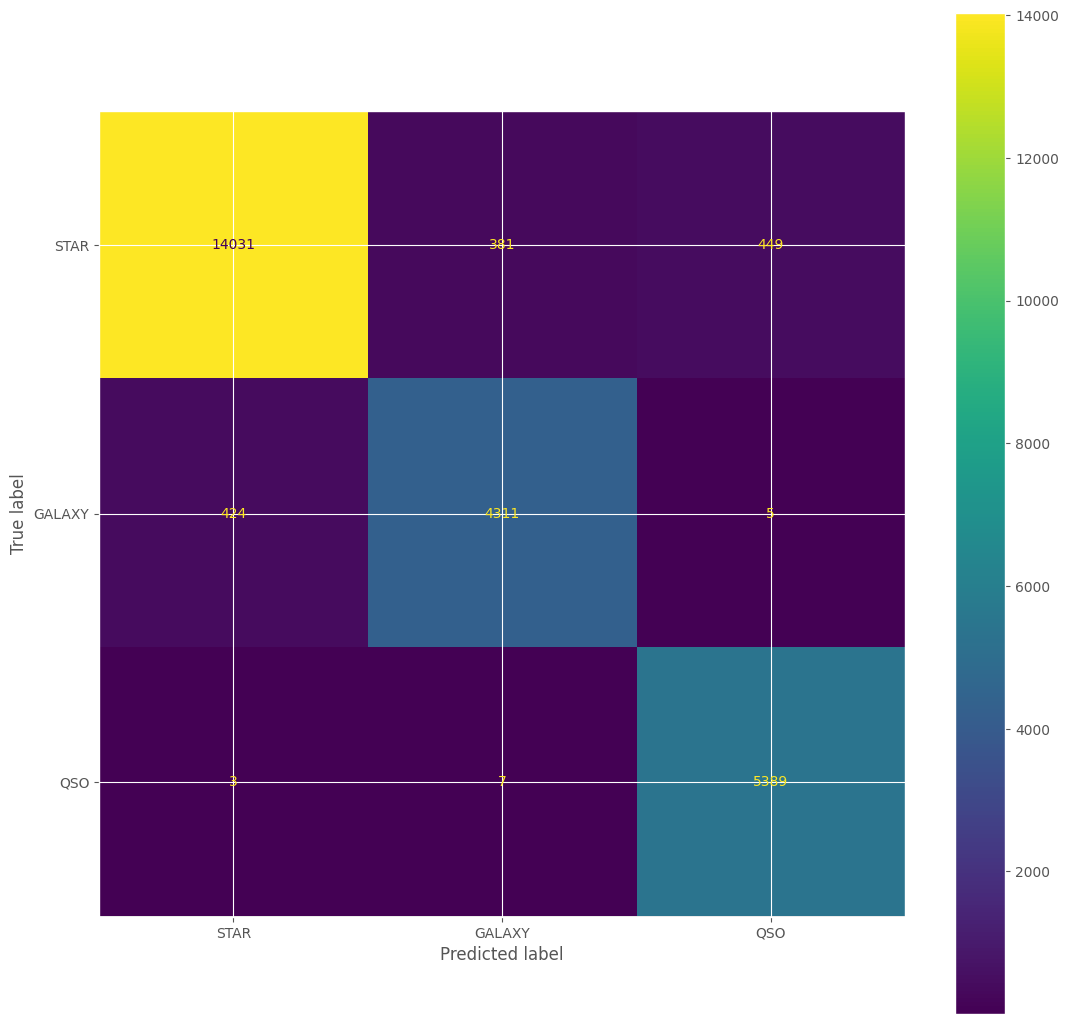

In [356]:
cmv2 = confusion_matrix(y_test, y_pred)
cmv2_display = ConfusionMatrixDisplay(cmv2, display_labels=['STAR', 'GALAXY', 'QSO'])
cmv2_display.plot()
plt.show()

MODELO COMPLETO

SELECCION DE VARIABLES

In [357]:
X_selected=datos[['alpha', 'delta', 'z', 'run_ID', 'cam_col', 'field_ID', 'redshift', 'fiber_ID']]

CLUSTERING

C:\Users\Josué\AppData\Local\Temp\ipykernel_29276\3617160750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['cluster'] = kmeans.fit_predict(X_selected)


[[1.80212236e+02 2.58445275e+01 1.86597023e+01 4.35062481e+03
  3.47360289e+00 1.89290948e+02 5.60386610e-01 4.39548454e+02]
 [1.71249812e+02 1.34533410e+01 1.92196222e+01 7.46421631e+03
  3.51122686e+00 1.84380882e+02 6.53956683e-01 4.85276535e+02]
 [1.78297229e+02 2.98563702e+01 1.82347796e+01 2.27416032e+03
  3.57878549e+00 1.82000250e+02 5.42134122e-01 4.37105107e+02]]


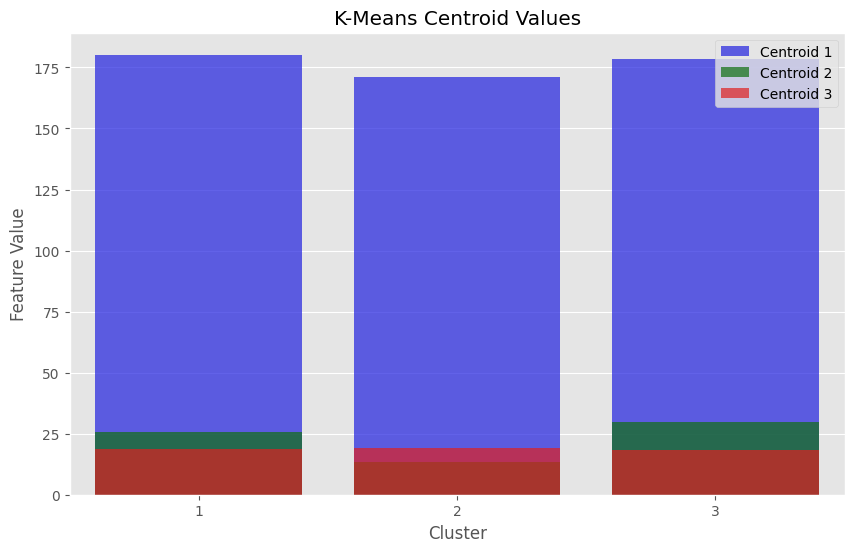

In [358]:
#%% Algoritmo de cluster
kmeans = KMeans(n_clusters=3,init='k-means++',n_init='auto', random_state=42).fit(X)
#init='random'
#init='ndarray'
# Obtener los centroides
X_selected['cluster'] = kmeans.fit_predict(X_selected)
C = kmeans.cluster_centers_
print(C)


# Configura el estilo de Seaborn
#sns.set(style="whitegrid")
# Crea un gráfico de barras para los centroides
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(C) + 1), y=C[:, 0], color='blue', alpha=0.7, label='Centroid 1')
sns.barplot(x=np.arange(1, len(C) + 1), y=C[:, 1], color='green', alpha=0.7, label='Centroid 2')
sns.barplot(x=np.arange(1, len(C) + 1), y=C[:, 2], color='red', alpha=0.7, label='Centroid 3')
plt.title('K-Means Centroid Values')
plt.xlabel('Cluster')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

In [359]:
df_final = pd.get_dummies(X_selected, columns=['cluster'], prefix='cluster', drop_first=True, dtype=float)

In [360]:
df_final

,alpha,delta,z,run_ID,cam_col,field_ID,redshift,fiber_ID,cluster_1,cluster_2
0,135.689107,32.494632,18.79371,3606,2,79,0.634794,171,0.0,0.0
1,144.826101,31.274185,21.61427,4518,5,119,0.779136,427,0.0,0.0
2,142.188790,35.582444,18.94827,3606,2,120,0.644195,299,0.0,0.0
3,338.741038,-0.402828,19.25010,4192,3,214,0.932346,775,0.0,0.0
4,345.282593,21.183866,15.54461,8102,3,137,0.116123,842,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,20.73569,7778,2,581,0.000000,438,1.0,0.0
99996,29.493819,19.798874,19.41526,7917,1,289,0.404895,866,1.0,0.0
99997,224.587407,15.700707,17.35221,5314,4,308,0.143366,74,0.0,0.0
99998,212.268621,46.660365,18.62482,3650,4,131,0.455040,470,0.0,0.0


PCA

In [361]:
# 1. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(df_final, Y, stratify=Y, random_state=42)

# 2. Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Escalar los datos después del SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Solo transformas el test, sin fit


In [362]:
pca=PCA()
X_train_transformada = pca.fit_transform(X_train_scaled)
X_test_transformada = pca.transform(X_test_scaled)
print(X_train_scaled.shape)
print(X_train_transformada.shape)

(133752, 10)
(133752, 10)


In [363]:
X_train_transformed = pd.DataFrame(X_train_transformada, columns = ['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8','CP9','CP10'])
X_test_transformed = pd.DataFrame(X_test_transformada, columns = ['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8','CP9','CP10'])
X_train_transformed

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10
0,0.281106,-2.378452,-1.100466,-0.474354,0.199578,-1.098663,0.145283,0.011070,-1.059412,0.023695
1,1.864536,-0.619071,-1.273355,0.427333,0.496302,-1.079884,0.208203,-0.323436,0.485203,-0.585586
2,-1.680072,1.556658,0.400100,-0.084371,-0.163685,-0.484142,0.022395,-0.853322,0.554373,0.389242
3,0.261123,0.002239,1.512703,0.747719,0.404940,-1.304497,1.051675,0.427636,-1.108046,0.277086
4,-1.900953,0.456164,-0.453151,1.347701,0.894880,0.225535,-0.063311,-1.866414,0.148358,-0.148445
...,...,...,...,...,...,...,...,...,...,...
133747,-1.333320,-3.279161,-0.659616,-1.013357,-0.241844,-0.054358,0.621322,-1.197374,0.284097,-0.192710
133748,-0.281492,-0.466126,-1.372507,0.222535,0.349261,0.512332,-0.592782,0.325128,-0.622583,-0.119849
133749,-0.549189,-0.619612,-1.745894,-0.315845,0.247007,-0.512123,-0.082907,0.857423,-0.577200,-0.248419
133750,2.232215,1.083617,-1.514957,0.677218,0.394787,0.910178,-0.068779,0.061647,1.022057,0.190375


In [364]:
#%% Validate the "recommended" PCA's
w,v = np.linalg.eig(pca.get_covariance()) # Get vectors for covariance matrix
w=np.abs(w)
indx = np.argsort(w)[::-1] # sort
porcentaje = w[indx]/np.sum(w) # convert to %
porcent_acum = np.cumsum(porcentaje) # Accumulate
porcent_acum

array([0.24287648, 0.37231014, 0.48679408, 0.58922881, 0.68762213,
       0.77288816, 0.85280389, 0.92986772, 0.99303322, 1.        ])

In [365]:
X_train = X_train_transformed[['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8']]
X_test = X_test_transformed[['CP1','CP2','CP3','CP4','CP5','CP6','CP7','CP8']]

MODELO

In [366]:
RegLog_final = LogisticRegression(penalty='l2', solver='lbfgs')

In [367]:
RegLog_final.fit(X_train, y_train_resampled)

LogisticRegression()

In [368]:
y_pred = RegLog_final.predict(X_test)
y_prob = RegLog_final.predict_proba(X_test)  # Probabilidad de la clase positiva

In [369]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob,multi_class='ovr',average='weighted'):.4f}")

Accuracy: 0.8998
Precision: 0.9050228088634147
F1-Score: 0.899941936385769
Recall: 0.8998
AUC-ROC: 0.9628


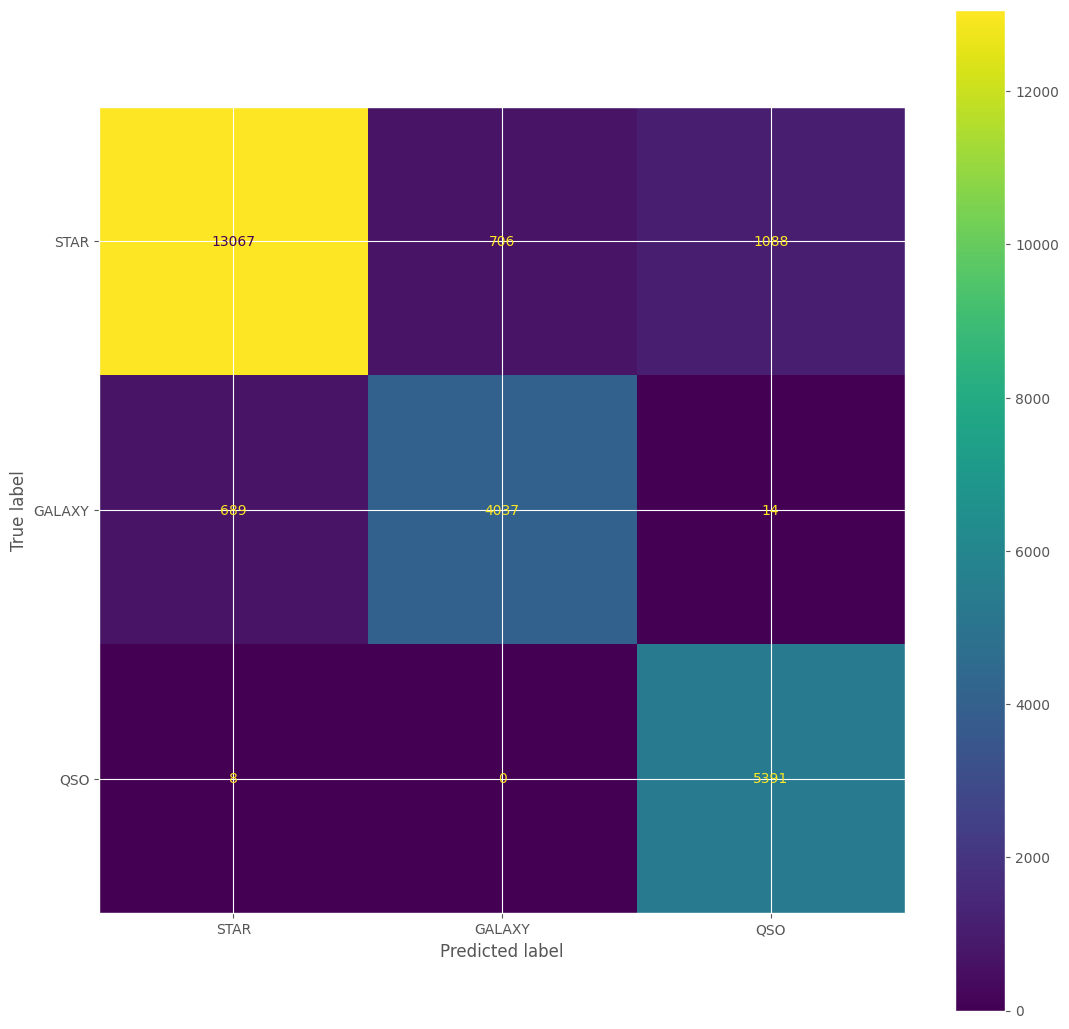

In [370]:
cmv2 = confusion_matrix(y_test, y_pred)
cmv2_display = ConfusionMatrixDisplay(cmv2, display_labels=['STAR', 'GALAXY', 'QSO'])
cmv2_display.plot()
plt.show()